# Imports

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit

import time

In [ ]:
tf.random.set_seed(0)

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



# Data loading

In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Pasteurizer_dataset/"

In [ ]:
train_df = pd.read_csv(path+ "centralized/train_set.csv")
test_df = pd.read_csv(path+ "centralized/test_set.csv")

In [ ]:
# No need for lagging variables for lstm

train_df.drop(['prev_water_temp','prev_can_temp'], axis=1, inplace=True)
test_df.drop(['prev_water_temp','prev_can_temp'], axis=1, inplace=True)

In [ ]:
feature_cols = ['paster_timeslot', 'curr_water_temp', 'bath_number', 'curr_bath_temp']

In [ ]:
test_df

# Preparing Data

In [ ]:
train_df.head()

In [ ]:
# Train test numpy arrays
X_train = train_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_train = train_df['curr_can_temp'].values


X_test = test_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_test = test_df['curr_can_temp'].values

In [ ]:
# gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)

# X_train, X_val = gss.split(X_train_full, groups = y_train_full)

In [ ]:
# Min max normalizaiton

min_max_scaler = preprocessing.MinMaxScaler()

X_train_norm_ = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)


In [ ]:
X_train.shape

(46972, 4)

In [ ]:
X_test.shape

(12178, 4)

# Sequence Creation

In [ ]:
# Receives single engine dataframe, window size and features -> sequences of length==window_size
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [ ]:
# Generates sequences for multiple engines
def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['paster_id'].unique()
        
    data_gen = (list(gen_train_data(df[df['paster_id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['paster_id'].unique()
        
    label_gen = [gen_labels(df[df['paster_id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [ ]:
sequence_length = 5

gss = GroupShuffleSplit(n_splits=1, train_size=0.95, random_state=42)


for train_unit, val_unit in gss.split(train_df['paster_id'].unique(), groups=train_df['paster_id'].unique()):
    train_unit = train_df['paster_id'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = train_df['paster_id'].unique()[val_unit]

    train_split_array = gen_data_wrapper(train_df, sequence_length, feature_cols, train_unit)
    train_split_label = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'], train_unit)
    
    val_split_array = gen_data_wrapper(train_df, sequence_length, feature_cols, val_unit)
    val_split_label = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'], val_unit)

# create sequences train, test 
X_train = gen_data_wrapper(train_df, sequence_length, feature_cols)
y_train = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'])

X_test = gen_data_wrapper(test_df, sequence_length, feature_cols)
y_test = gen_label_wrapper(test_df, sequence_length, ['curr_can_temp'])

In [ ]:
X_train.shape

(46124, 5, 4)

# Model Definition

In [ ]:
# Defining LSTM model

model = tf.keras.Sequential()
# model.add(tf.keras.layers.Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, 4)))

model.add(tf.keras.layers.LSTM(32, activation='tanh'))

# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))


In [ ]:
# InputLayer(input_shape=(20, 18)),  
(sequence_length, X_train.shape[2])

(5, 4)

# Training


In [ ]:
start = time.time()



model.compile(loss='mean_squared_error', optimizer="adam", metrics = 'mean_absolute_error')  # the model is recompiled to reset the optimizer

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=15,
                   batch_size=32)
end = time.time()
print(f"Training time {end - start:.2f} sec")

Epoch 1/15
1369/1369 [==============================] - 14s 6ms/step - loss: 1167.0315 - mean_absolute_error: 31.3235 - val_loss: 329.6640 - val_mean_absolute_error: 16.3778
Epoch 2/15
1369/1369 [==============================] - 7s 5ms/step - loss: 144.1024 - mean_absolute_error: 10.2532 - val_loss: 52.6944 - val_mean_absolute_error: 6.4025
Epoch 3/15
1369/1369 [==============================] - 5s 3ms/step - loss: 41.9658 - mean_absolute_error: 5.3882 - val_loss: 39.8531 - val_mean_absolute_error: 4.9811
Epoch 4/15
1369/1369 [==============================] - 4s 3ms/step - loss: 38.0651 - mean_absolute_error: 4.8663 - val_loss: 39.4837 - val_mean_absolute_error: 4.8549
Epoch 5/15
1369/1369 [==============================] - 4s 3ms/step - loss: 37.7578 - mean_absolute_error: 4.8195 - val_loss: 39.3335 - val_mean_absolute_error: 4.8259
Epoch 6/15
1369/1369 [==============================] - 4s 3ms/step - loss: 32.5179 - mean_absolute_error: 4.4246 - val_loss: 19.3004 - val_mean_absolut

# Evaluation

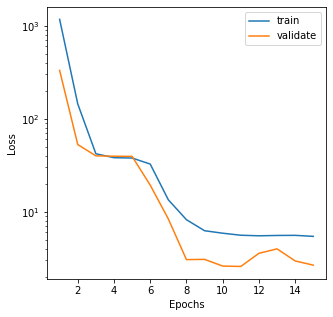

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

plot_loss(history)

In [ ]:

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat,squared=False)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, MSE:{}, MAE:{}, R2:{}'.format(label, rmse, mse, mae, variance))

In [ ]:
# predict and evaluate
y_hat_train = model.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = model.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:2.2072746753692627, MSE:4.872061729431152, MAE:1.394304871559143, R2:0.9398615313536425
test set RMSE:2.254263162612915, MSE:5.081702709197998, MAE:1.4704691171646118, R2:0.9388955790617473


In [ ]:
y_test

array([[29.2 ],
       [29.84],
       [30.5 ],
       ...,
       [42.69],
       [42.41],
       [42.17]], dtype=float32)

In [ ]:
# y_hat_test.reshape(11966,)